<a href="https://colab.research.google.com/github/dhguslee/leedo/blob/main/Machine%20Learning%20Code/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN (Convolution Neural Network)**
---

### **I. 이산 합성곱 (discrete convolution)**

#### **1차원 합성곱 계산 구현**

$$y = x * w  \rightarrow y[i] = \sum_{k = -inf}^{+inf}x[i-k]w[k] 　　　　　(x = Input data, 　w = Filter or Kernel) $$

\

For example, if $x= \{0,1,2,\cdots,8,9\}$, 　Index of $\ -inf : -1\ $  and $\ 10:+inf\ $ is out of $\ x$ range. 
 - Assume : 
    - $x\ and\ w$ are filled 0(zero)
    - output $\ y$ is filled 0(zero)
 
 - It is called (Zero) Padding.


\

\

So, The folmula changes 
$$y = x * w  \rightarrow y[i] = \sum_{k = 0}^{m-1}x^{p}[i+m-k]w[k] $$


In [15]:
import numpy as np

def conv1d(x, w, p = 0, s = 1) :    # default : Padding 없이, Stride = 1
  
  w_rot = np.array(w[: : -1])
  x_padded = np.array(x)

  if p > 0 :
    zero_pad = np.zeros(shape = p)
    x_padded = np.concatenate([zero_pad, x_padded, zero_pad])

  res = []
  for i in range(0, int(len(x)/s), s) :       # Stride 만큼 이동해가며 계산
    res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))

  return np.array(res)


### Test

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print("Conv1d 구현 :", conv1d(x, w, p = 2, s = 1))

print("넘파이 결과 :", np.convolve(x, w, mode = "same"))  # np.convolve : 1차원 합성곱 계산 함수식

Conv1d 구현 : [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과 : [ 5 14 16 26 24 34 19 22]


#### **2차원 합성곱**

$$ Y = X*W \rightarrow Y[i, j] = \sum_{k_{1}=-inf}^{+inf}\sum_{k_{2}=-inf}^{+inf}X[i_k{1}, j-k_{j}]\ W[k_{1},k_{2}]$$
\
$$(m_{1} ≤ n_{1} ,\ \ \ m_{2} ≤ n_{2})$$

In [16]:
import numpy as np
import scipy.signal

def conv2d(X, W, p = (0, 0), s = (1,1)) :

  W_rot = np.array(W)[::-1, ::-1]
  X_orig = np.array(X)
  n1 = X_orig.shape[0] + 2*p[0]             # 입력값 행길이 + 패딩 개수
  n2 = X_orig.shape[1] + 2*p[1]             # 입력값 열길이 + 패딩 개수
  X_padded = np.zeros(shape = (n1, n2))     # 위 크기만큼 영벡터 생성

  # print("W :", W_rot, "\n", "X_orig : ", X_orig, "\n", "n1 :", n1, "\n", "n2 : ", n2, "\n", "X_padded1 :", X_padded)
  
  X_padded[p[0] : p[0] + X_orig.shape[0],
           p[1] : p[1] + X_orig.shape[1]] = X_orig    # 위 영벡터에서 패딩 외의 부분에 X값을 입력.

  # print("X_padded2 : " , X_padded)


  res = []

  for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0]) + 1, s[0]) :   # 세로 이동

    res.append([])    # 빈 리스트 추가

    for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1]) + 1, s[1]) : # 가로 이동

      X_sub = X_padded[i : i+W_rot.shape[0], j : j+W_rot.shape[1]]    # X에서 합성곱이 진행되는 일부분을 X_sub으로 저장
      res[-1].append(np.sum(X_sub * W_rot))                           # 맨 뒤 or 새로 생긴 리스트에 계산값 추가.

  return (np.array(res))


X = [[1, 3, 2, 4],
     [5, 6, 1, 3],
     [1, 2, 0, 2],
     [3, 4,3 , 2]]

W = [[1, 0, 3],
     [1, 2, 1],
     [0, 1, 1]]
  

print("Conv1d 구현 :", conv2d(X, W, p = (1, 1), s = (1, 1)))

print("넘파이 결과 :", scipy.signal.convolve2d(X, W, mode = "same"))  

Conv1d 구현 : [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
넘파이 결과 : [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### **II. 다층 CNN**

#### **0. MMIST 데이터 다운로드**

In [ ]:
!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-images-idx3-ubyte.gz
!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/t10k-labels-idx1-ubyte.gz
!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-images-idx3-ubyte.gz
!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch12/train-labels-idx1-ubyte.gz  

In [18]:
# MNIST 데이터 압축을 푸는 코드

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

In [19]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

print("현재 경로 : ", os.getcwd())

현재 경로 :  /content


#### **1. 데이터 적재와 전처리**

In [20]:
### 데이터 적재

X_data, y_data = load_mnist("/content/", kind = "train")
print("행 : {}, 열 : {}".format(X_data.shape[0], X_data.shape[1]))

X_test, y_test = load_mnist("/content", kind = "t10k")
print("행 : {}, 열 : {}".format(X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[ : 50000, :], y_data[ : 50000]
X_valid, y_valid = X_data[50000 : , :], y_data[50000 : ]

print("훈련 세트 : ", X_train.shape, y_train.shape)
print("검증 세트 : ", X_valid.shape, y_valid.shape)
print("테스트 세트 : ", X_test.shape, y_test.shape)

행 : 60000, 열 : 784
행 : 10000, 열 : 784
훈련 세트 :  (50000, 784) (50000,)
검증 세트 :  (10000, 784) (10000,)
테스트 세트 :  (10000, 784) (10000,)


In [21]:
### 정규화

mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)       # 모든 샘플에서 고정된 값이면 변동이 없고 표준편차가 0이 되므로 0-나눗셈 에러 발생
                                # 이런 이유 때문에 X_train 전체의 표준편차를 계산하기 위해 np.std함수의 axis 매개변수를 지정하지 않는다.

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

In [22]:
### 2차원 배열 데이터를 원본 이미지와 동일한 28x28x1 크기로 변경

X_train_centered = X_train_centered.reshape((-1, 28, 28, 1))
X_valid_centered = X_valid_centered.reshape((-1, 28, 28, 1))
X_test_centered = X_test_centered.reshape((-1, 28, 28, 1))

X_train_centered.shape    # 데이터 수, height, width, channels

(50000, 28, 28, 1)

In [23]:
### 클래스 레이블을 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

y_train[0:3], y_train_onehot[0:3]

(array([5, 0, 4], dtype=uint8),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32))

In [24]:
### 변경된 훈련, 검증, 테스트 세트의 크기 출력.

print("훈련 세트 :", X_train_centered.shape, y_train_onehot.shape)
print("검증 세트 :", X_valid_centered.shape, y_valid_onehot.shape)
print("테스트 세트 :", X_test_centered.shape, y_test_onehot.shape)

훈련 세트 : (50000, 28, 28, 1) (50000, 10)
검증 세트 : (10000, 28, 28, 1) (10000, 10)
테스트 세트 : (10000, 28, 28, 1) (10000, 10)


#### **2. 텐서플로 tf.keras API로 CNN 구성**

In [25]:
from tensorflow.keras import layers, models

model = models.Sequential()   # Sequential 모델 생성

model.add(layers.Conv2D(32, (5, 5),           # 32개의 필터 개수, 필터 크기 = 5x5x1
                        padding = "valid",    # Valid = 패딩 없음(p=0)
                        activation = "relu", 
                        input_shape = (28, 28, 1)))   # 28x28x1 -> 24x24x32
                                                      # 이 층의 가중치 개수 : (5x5x1) x 32 + 32 = 832개

model.add(layers.MaxPool2D((2, 2)))   # 최대 풀링 층  / 24x24x32 -> 12x12x32 / 가중치 없음

model.add(layers.Conv2D(64, (5,5),              # 필터 크기 5x5x32이며, 64개
                        padding = "valid",
                        activation = "relu"))   # 12x12x32 -> 8x8x64
                                                # 이 층의 가중치 개수 : (5x5x32) x 64 +64 = 51,264개

model.add(layers.MaxPool2D((2, 2)))   # 8x8x64 -> 4x4x64


model.add(layers.Flatten())    # 4x4x64 -> 1024x1

model.add(layers.Dense(1024,        # (1024개의 텐서를) 1024개의 유닛을 가진 층에 완전 연결
                       activation = "relu"))    # 가중치 개수 1024 x 1024 + 1024 = 1,049,600개

model.add(layers.Dropout(0.5))      # 편리하게 모델의 fit메서드에서만 적용 
                                      # (즉, 테스트나 평가를 위해 모델 구성을 바꿀 필요가 없다.)

model.add(layers.Dense(10, activation = "softmax"))   # 가중치 개수 1024 x 10 + 10 = 10,250개


print("모델 층별 출력 차원 밒 가중치 개수 : ", model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

#### **3. 합성곱 신경망 모델 훈련**

##### **1) Model Compile**

In [26]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["acc"])

##### **2) Weights 저장**

In [28]:
# ### 가중치 저장

import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# 검증손실(val_loss)을 모니터링하고 최상의 가중치를 cnn_checkpoint.h5파일에 저장.
callback_list = [ModelCheckpoint(filepath = "cnn_checkpoint.h5",      
                                 monitor = "val_loss",
                                 save_best_only = True),
                 
                 # logs 디렉터리 하위에 서브디렉터리를 만들어 통계를 저장.
                 TensorBoard(log_dir="logs/{}".format(time.asctime()))]   # time.asctime() : 현재 시간을 사용해 서브디렉터리를 생성

history = model.fit(X_train_centered, y_train_onehot, 
                    batch_size = 64,    # default = 32
                    epochs = 20, 
                    validation_data = (X_valid_centered, y_valid_onehot),
                    callbacks = callback_list)



Epoch 1/20
782/782 [==============================] - 65s 82ms/step - loss: 0.2916 - acc: 0.9085 - val_loss: 0.0503 - val_acc: 0.9845
Epoch 2/20
782/782 [==============================] - 75s 96ms/step - loss: 0.0525 - acc: 0.9829 - val_loss: 0.0387 - val_acc: 0.9886
Epoch 3/20
782/782 [==============================] - 66s 84ms/step - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0330 - val_acc: 0.9907
Epoch 4/20
782/782 [==============================] - 65s 83ms/step - loss: 0.0268 - acc: 0.9920 - val_loss: 0.0354 - val_acc: 0.9901
Epoch 5/20
782/782 [==============================] - 64s 82ms/step - loss: 0.0211 - acc: 0.9933 - val_loss: 0.0311 - val_acc: 0.9919
Epoch 6/20
782/782 [==============================] - 65s 83ms/step - loss: 0.0184 - acc: 0.9944 - val_loss: 0.0354 - val_acc: 0.9909
Epoch 7/20
782/782 [==============================] - 65s 83ms/step - loss: 0.0164 - acc: 0.9941 - val_loss: 0.0374 - val_acc: 0.9907
Epoch 8/20
782/782 [==============================] - 66s 84ms

##### **3) Loss and Accuracy Graphs**

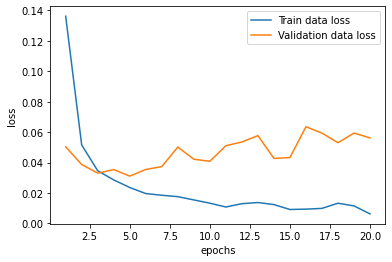

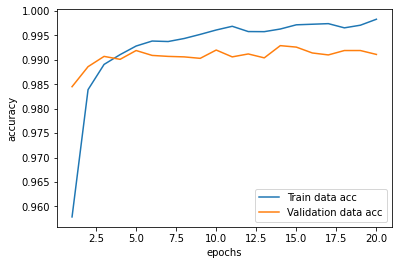

In [29]:
### 훈련 세트와 테스트 세트에 대한 손실과 정확도
import matplotlib.pyplot as plt
import numpy as np

# 손실 그래프
epochs = np.arange(1, 21)
plt.plot(epochs, history.history["loss"], label = "Train data loss")
plt.plot(epochs, history.history["val_loss"], label = "Validation data loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(epochs, history.history["acc"], label = "Train data acc")
plt.plot(epochs, history.history["val_acc"], label = "Validation data acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

##### **4) Tensorboard**

In [ ]:
# $ls -al logs/

# $tensorboard -- logdir logs/

##### **5) Model Save and Restore**

In [32]:
### 모델 저장하기

model.save("cnn_model.h5")  # cnn_model.h5 파일 이름으로 모델 저장

### 모델 불러오기

from tensorflow.keras.models import load_model

# 저장된 모델을 다시 불러 새로운 모델 객체 생성
restored_model = load_model("cnn_model.h5")

# 가장 높은 서능의 가중치가 저장된 체크포인트 파일 복원
restored_model.load_weights("cnn_checkpoint.h5")

In [33]:
### 복원된 Model로 Test set에서 평가하기

restored_model.evaluate(X_train_centered, y_train_onehot) 

1563/1563 [==============================] - 19s 12ms/step - loss: 0.0088 - acc: 0.9971


[0.00878419354557991, 0.9970999956130981]

##### **6) Predict value Vizualization**

In [34]:
### 테스트 샘플 중 첫 10개 데이터 확인
print("예측 : ", np.argmax(restored_model.predict(X_test_centered[:10]), axis = 1),
      "\n"
      "실제 : ", y_test[:10])

예측 :  [7 2 1 0 4 1 4 9 5 9] 
실제 :  [7 2 1 0 4 1 4 9 5 9]


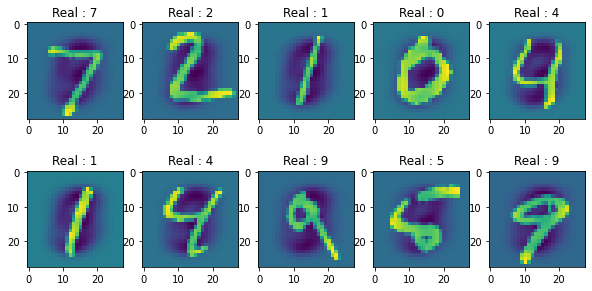

In [35]:
### 예측결과 시각화

fig = plt.figure(figsize = (10, 5))

for i in range(10) :
  fig.add_subplot(2, 5, i+1)
  plt.imshow(X_test_centered[i].reshape(28, 28))  # 784개의 열 -> 28x28 배열
  plt.title("Real : {}".format(y_test[i]))

#### **4. 활성화 출력과 필터 시각화**

##### **1) 첫 번째 합성곱 층 생성**

In [36]:
### 첫 번째 합성곱 층의 출력을 이미지로 시각화

first_layer = model.layers[0]
print(first_layer)  # Conv2D층이라는 것을 알 수 있다.
print(first_layer.output)

print(model.input)  # input_shape = (None, 28 x 28 x 1)로 지정했음을 알 수 있으며 None = 배치 차원을 의미

# 입력과 출력 텐서를 연결한 새로운 모델 생성.
first_activation = models.Model(inputs = model.input,
                                outputs = first_layer.output)

activation = first_activation.predict(X_test_centered[:10])

print(activation.shape)   # (10, 24, 24, 32) : 10개의 테스트 샘플을 입력했으므로 첫번째 배치 차원= 10

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 24, 32), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_2_input'), name='conv2d_2_input', description="created by layer 'conv2d_2_input'")
(10, 24, 24, 32)


##### **2) 첫 번째 합성곱층 샘플의 "Feature Map" 시각화**

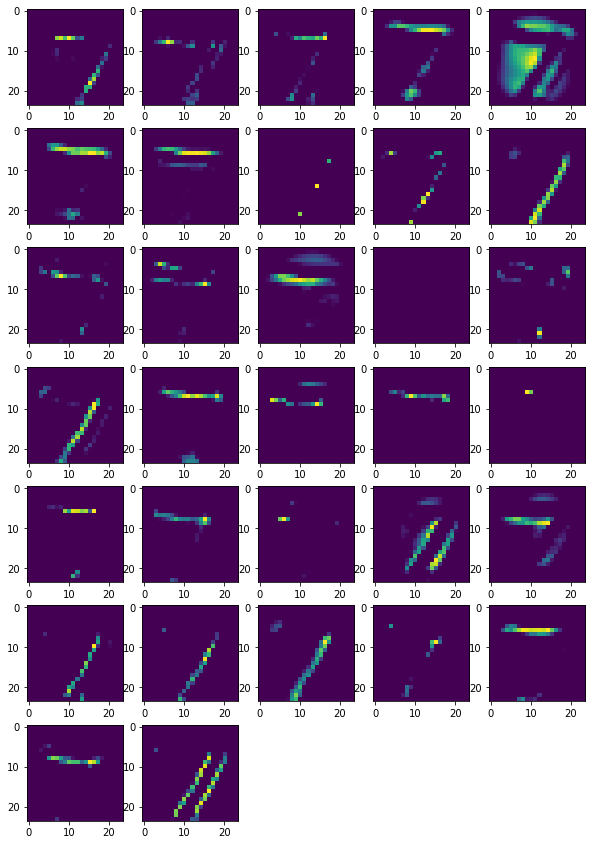

In [37]:
### 열개의 샘플 중 첫 번째 샘플의 특성맵 32개를 모두 출력.

fig = plt.figure(figsize = (10, 15))

for i in range(32) :
  fig.add_subplot(7, 5, i+1)
  plt.imshow(activation[0, :, :, i])

# # 네 번째 숫자의 특성맵

# fig = plt.figure(figsize = (10, 15))

# for i in range(32) :
#   fig.add_subplot(7, 5, i+1)
#   plt.imshow(activation[3, :, :, i])


##### **3) 첫 번째 합성곱층 샘플의 "Filter" 시각화**

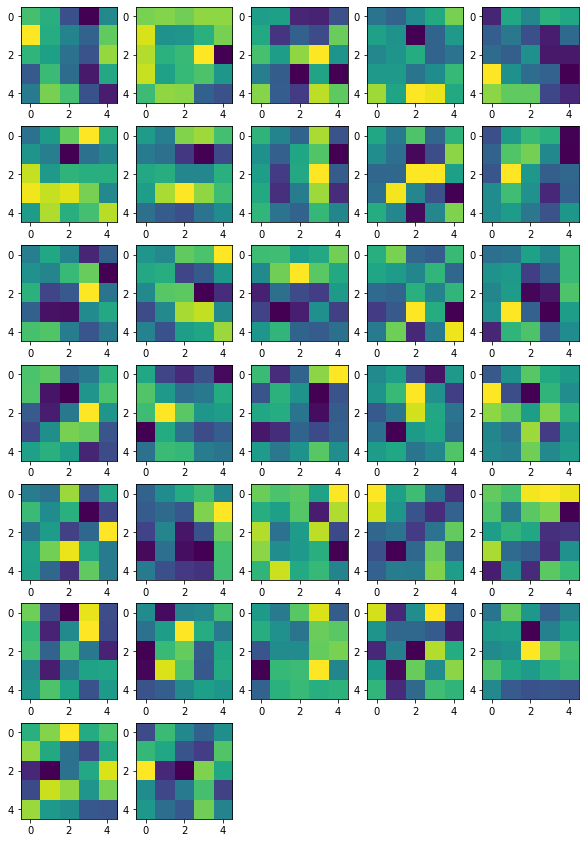

In [38]:
### 첫 번째 층의 필터를 출력
  # 합성곱 필터는 합성곱 층의 kernel 속성에 저장되어 있다.

fig = plt.figure(figsize = (10, 15))

for i in range(32) :
  fig.add_subplot(7, 5, i+1)
  plt.imshow(first_layer.kernel[:, :, 0, i])        # (높이, 너비, 입력 채널, 출력 채널) : grayscale로 입력채널은 1개이므로 인덱스를 0으로 고정.
                                                    # 필터의 밝은 부분이 높은 값을 의미.
                                                    # 예를들어 9번째 필너틑 수평 에지를 학습하는 것으로 보인다.

##### **4) 두 번째 Conv2D 층** 

(10, 8, 8, 64)


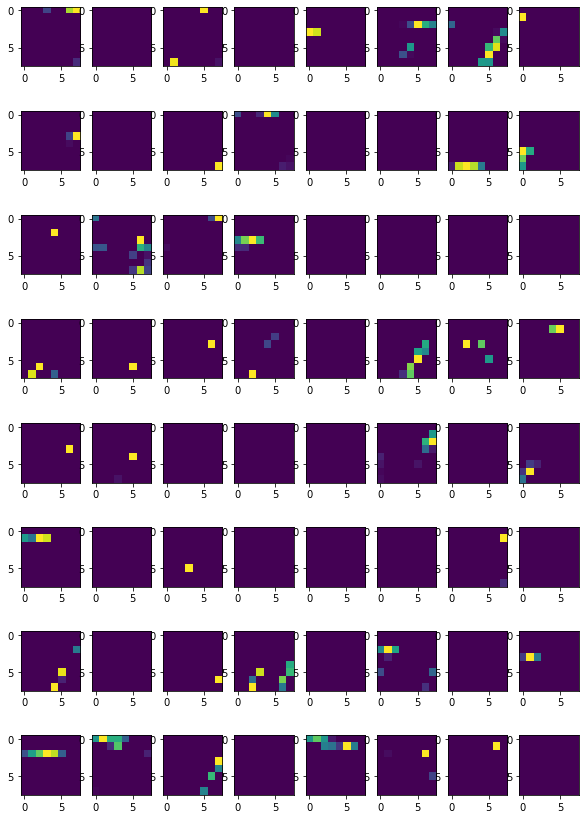

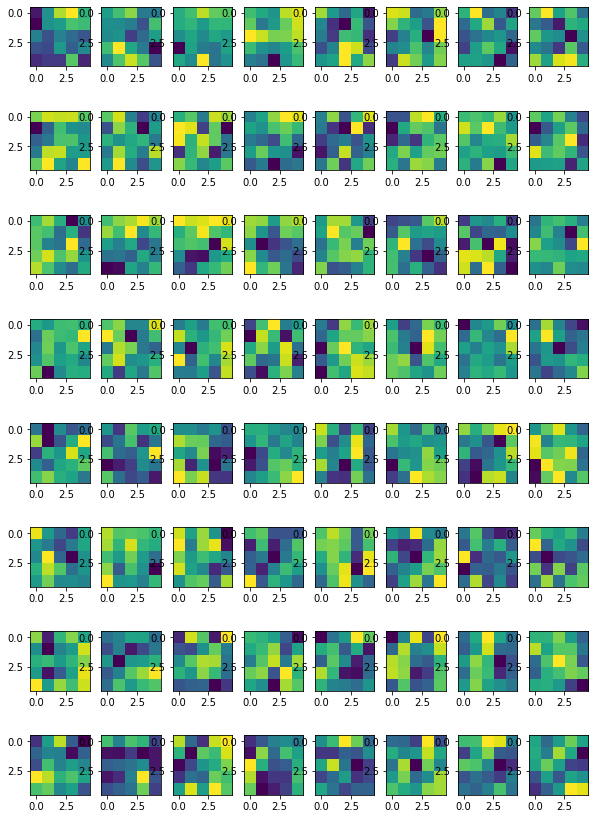

In [39]:
second_conv2d = model.layers[2]

second_activation = models.Model(inputs = model.input,
                                 outputs = second_conv2d.output)

activation2 = second_activation.predict(X_test_centered[:10])

print(activation2.shape)

fig = plt.figure(figsize = (10, 15))

for i in range(64) :
  fig.add_subplot(8, 8, i+1)
  plt.imshow(activation2[0, :, :, i])


fig = plt.figure(figsize = (10, 15))

for i in range(64) :
  fig.add_subplot(8, 8, i+1)
  plt.imshow(second_conv2d.kernel[:, :, 0, i])   